In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

import seaborn as sns

In [2]:
palette = sns.color_palette('viridis', n_colors=8)
palette

[(0.281412, 0.155834, 0.469201),
 (0.244972, 0.287675, 0.53726),
 (0.190631, 0.407061, 0.556089),
 (0.147607, 0.511733, 0.557049),
 (0.119699, 0.61849, 0.536347),
 (0.20803, 0.718701, 0.472873),
 (0.430983, 0.808473, 0.346476),
 (0.709898, 0.868751, 0.169257)]

# Lotka-Volterra equations (Cycle model)

\begin{align}
\dot X_1 &= a_0 X_1 - a_1 X_1 - a_2 X_1 X_2 + a_3 X_1 X_3 \\
\dot X_2 &= a_4 X_1 X_2 - a_5 X_2 - a_6 X_2 X_3 \\
\dot X_3 &= -a_7 X_1 X_3 + a_8 X_2 X_3 - a_9 X_3 \\
\end{align}

In [3]:
def modelLV(Y, t, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9):
    X1, X2, X3 = Y
    
    dX1 = a0*X1 - a1*X1 - a2*X1*X2 + a3*X1*X3
    dX2 = a4*X1*X2 - a5*X2 - a6*X2*X3
    dX3 = -a7*X1*X3 + a8*X2*X3 - a9*X3
    
    return [dX1, dX2, dX3]

In [4]:
a0 = 0.0 # Reproduction rate of X1
a1 = 0.18 # Mortality rate of X1
a2 = 0.16 # Rate of predation of X2 on X1
a3 = 0.15 # Reproduction rate of X1 in presence of X3
a4 = 0.11 # Reproduction rate of X2 in presence of X1
a5 = 0.01 # Mortality rate of X2
a6 = 0.12 # Rate of predation of X3 on X2
a7 = 0.05 # Rate of predation of X1 on X3
a8 = 0.12 # Reproduction rate of X3 in presence of X2
a9 = 0.01 # Mortality rate of X3

In [16]:
names=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9']

In [6]:
dfGroundPars = pd.DataFrame([a0, a1, a2, a3, a4, a5, a6, a7, a8, a9]).T
dfGroundPars.columns = names

In [7]:
dfGroundPars

,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9
0,0.0,0.18,0.16,0.15,0.11,0.01,0.12,0.05,0.12,0.01


# Generating data

In [161]:
a0 = dfGroundPars['a0'][0]
a1 = dfGroundPars['a1'][0]
a2 = dfGroundPars['a2'][0]
a3 = dfGroundPars['a3'][0]
a4 = dfGroundPars['a4'][0]
a5 = dfGroundPars['a5'][0]
a6 = dfGroundPars['a6'][0]
a7 = dfGroundPars['a7'][0]
a8 = dfGroundPars['a8'][0]
a9 = dfGroundPars['a9'][0]

In [162]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)
dt = t[1]-t[0]

In [163]:
sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))

In [164]:
X1_g = sol[:,0]
X2_g = sol[:,1]
X3_g = sol[:,2]

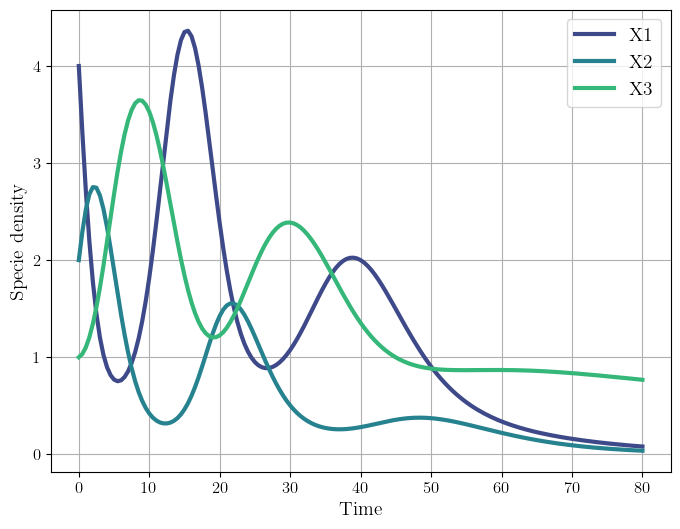

In [165]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

axs.plot(t, X1_g, lw=3, color=palette[1], label='X1')
axs.plot(t, X2_g, lw=3, color=palette[3], label='X2')
axs.plot(t, X3_g, lw=3, color=palette[5], label='X3')
axs.legend(loc='best')
axs.set_xlabel('Time')
axs.set_ylabel('Specie density')
axs.grid()

plt.show()

In [166]:
dfData_clean = pd.DataFrame(np.transpose([t[0::10],X1_g[0::10],X2_g[0::10],X3_g[0::10]]), columns=['Time','X1','X2','X3'])
# dfData_clean = pd.DataFrame(np.transpose([t, X1_g, X2_g, X3_g]), columns=['Time','X1','X2','X3'])

In [192]:
data = []
std = 0.25
samples = 5
for i in range(len(dfData_clean)):
    time = dfData_clean['Time'][i]
    x1 = dfData_clean['X1'][i]
    x2 = dfData_clean['X2'][i]
    x3 = dfData_clean['X3'][i]
    for j in range(samples):
        aux = [time, np.random.normal(x1, std), np.random.normal(x2, std), np.random.normal(x3, std)]
        data.append(aux)

# dfData_noise = pd.DataFrame(data, columns=['Time','X1','X2','X3'])
dfData = pd.DataFrame(data, columns=['Time','X1','X2','X3'])

# Recovering parameters

In [82]:
dfParams_ground = dfGroundPars.drop(columns=['a0']).melt(var_name='Parameters', value_name='Values')

In [83]:
parNames=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'RMSE']

In [184]:
dfData = pd.read_csv('cycle/LVdata_noise.data', sep=' ')

## Quantitative X1

In [136]:
dfParams = pd.read_csv('cycle/bestPars_quant.dat', sep=' ', names=parNames)

In [137]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

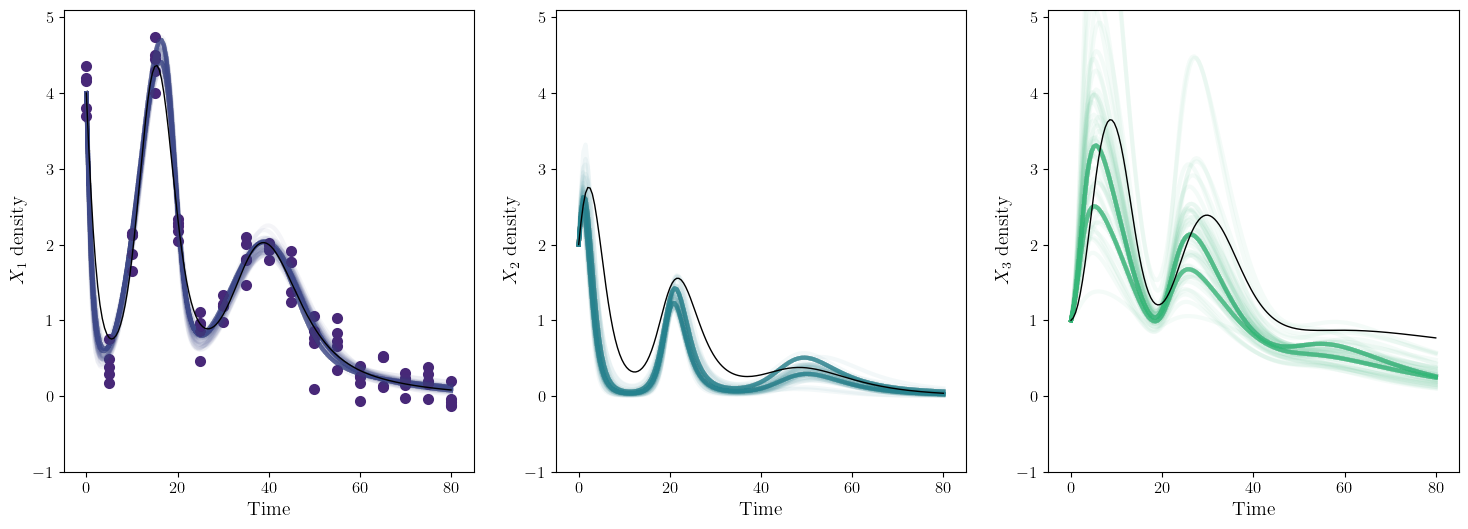

In [191]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), ylim=(-1,5.1), xlabel='Time')

plt.show()

In [110]:
dfParams_quant = dfParams.drop(columns=['a0', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

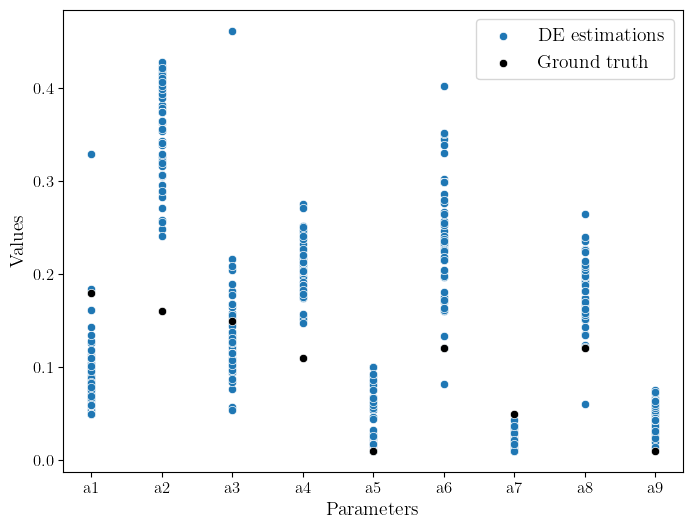

In [111]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

sns.scatterplot(dfParams_quant, x='Parameters', y='Values', label='DE estimations')
sns.scatterplot(dfParams_ground, x='Parameters', y='Values', label='Ground truth', color='k')

## Qualitative X2

In [127]:
dfQual_x2 = pd.read_csv('cycle/LVdata_qual_x2.data', sep=' ')

In [128]:
dfParams = pd.read_csv('cycle/bestPars_x2.dat', sep=' ', names=parNames)

In [129]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

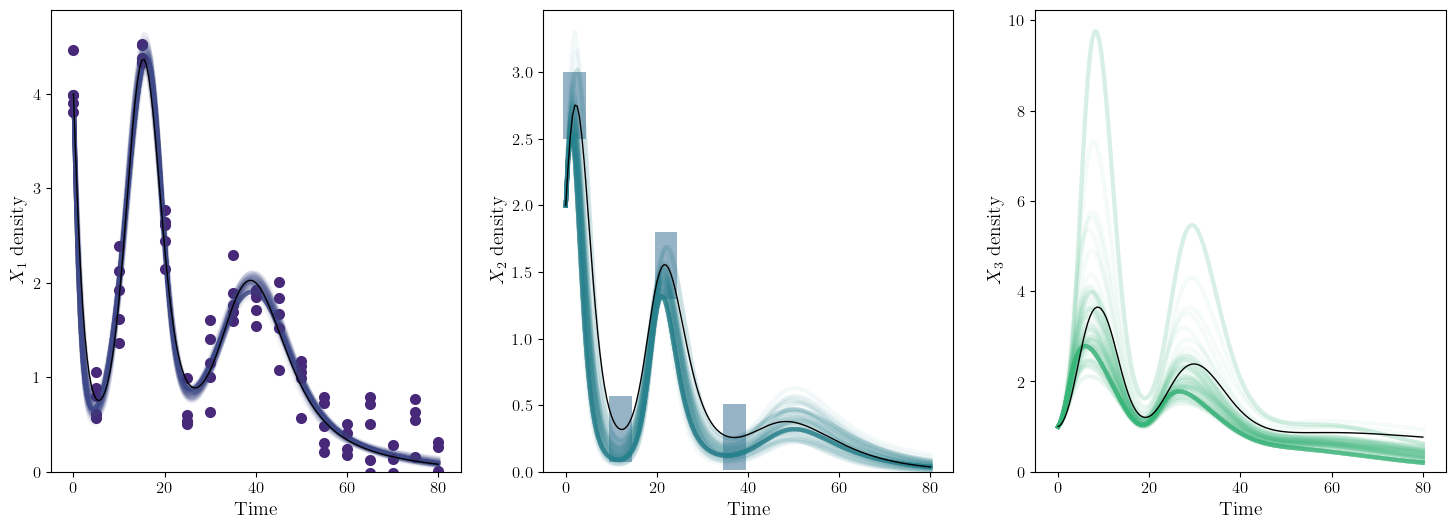

In [133]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5
for i in range(len(dfQual_x2['Time'])):
    rect = plt.Rectangle((dfQual_x2['Time'].values[i]- timeWindow/2, dfQual_x2['X2'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[2], alpha = 0.5)
    axs[1].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), xlabel='Time', ylim=(0))

plt.show()

In [134]:
dfParams_x2 = dfParams.drop(columns=['a0', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

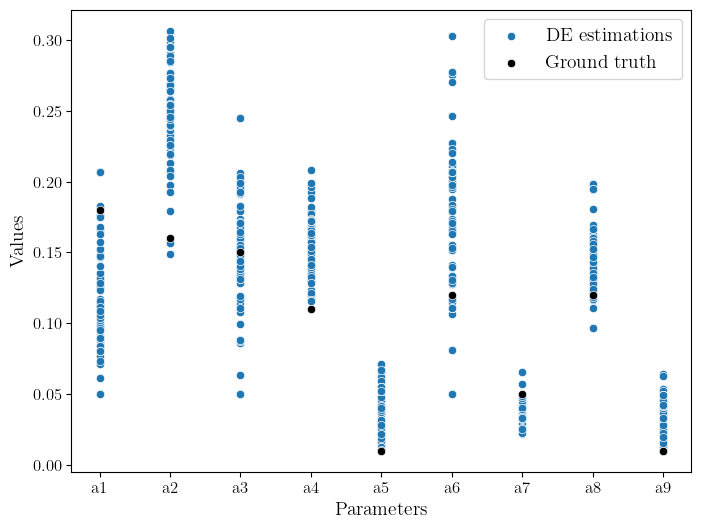

In [135]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

sns.scatterplot(dfParams_x2, x='Parameters', y='Values', label='DE estimations')
sns.scatterplot(dfParams_ground, x='Parameters', y='Values', label='Ground truth', color='k')

## Qualitative X3

In [116]:
dfQual_x3 = pd.read_csv('cycle/LVdata_qual_x3.data', sep=' ')

In [117]:
dfParams = pd.read_csv('cycle/bestPars_x3.dat', sep=' ', names=parNames)

In [118]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

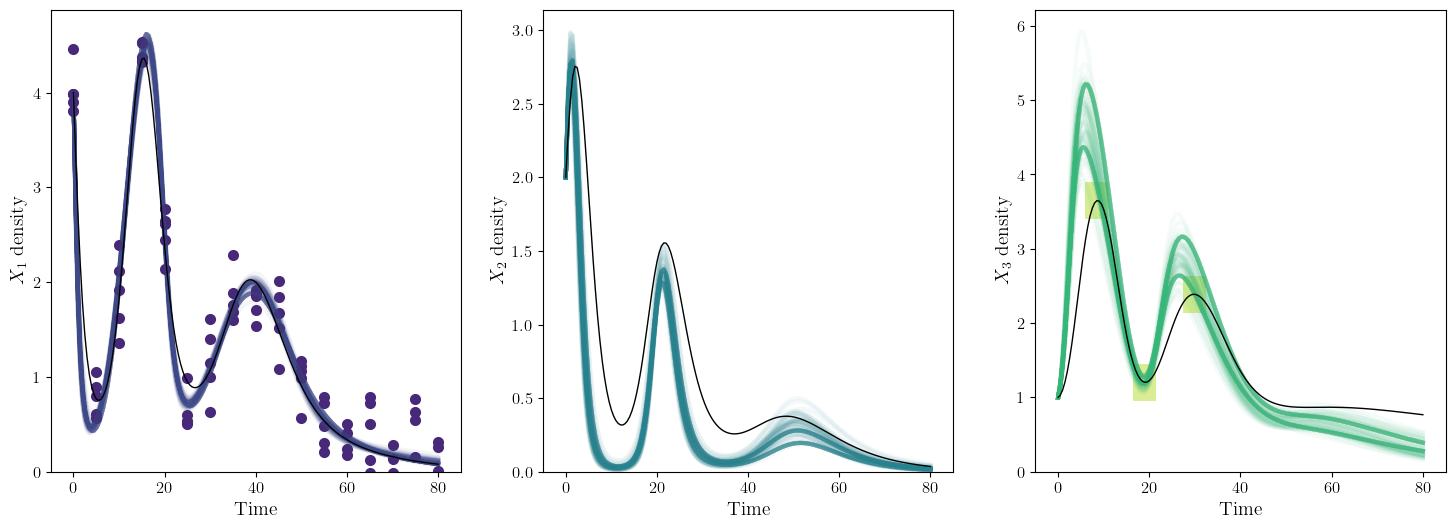

In [119]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5
for i in range(len(dfQual_x3['Time'])):
    rect = plt.Rectangle((dfQual_x3['Time'].values[i]- timeWindow/2, dfQual_x3['X3'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), xlabel='Time', ylim=(0))

plt.show()

In [120]:
dfParams_x3 = dfParams.drop(columns=['a0', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

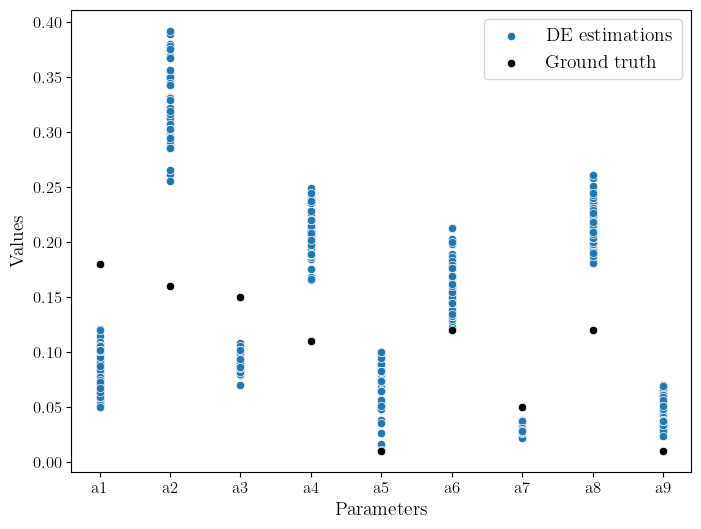

In [121]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

sns.scatterplot(dfParams_x3, x='Parameters', y='Values', label='DE estimations')
sns.scatterplot(dfParams_ground, x='Parameters', y='Values', label='Ground truth', color='k')

## Qualitative X2 and X3

In [122]:
dfParams = pd.read_csv('cycle/bestPars_x2x3.dat', sep=' ', names=parNames)

In [123]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

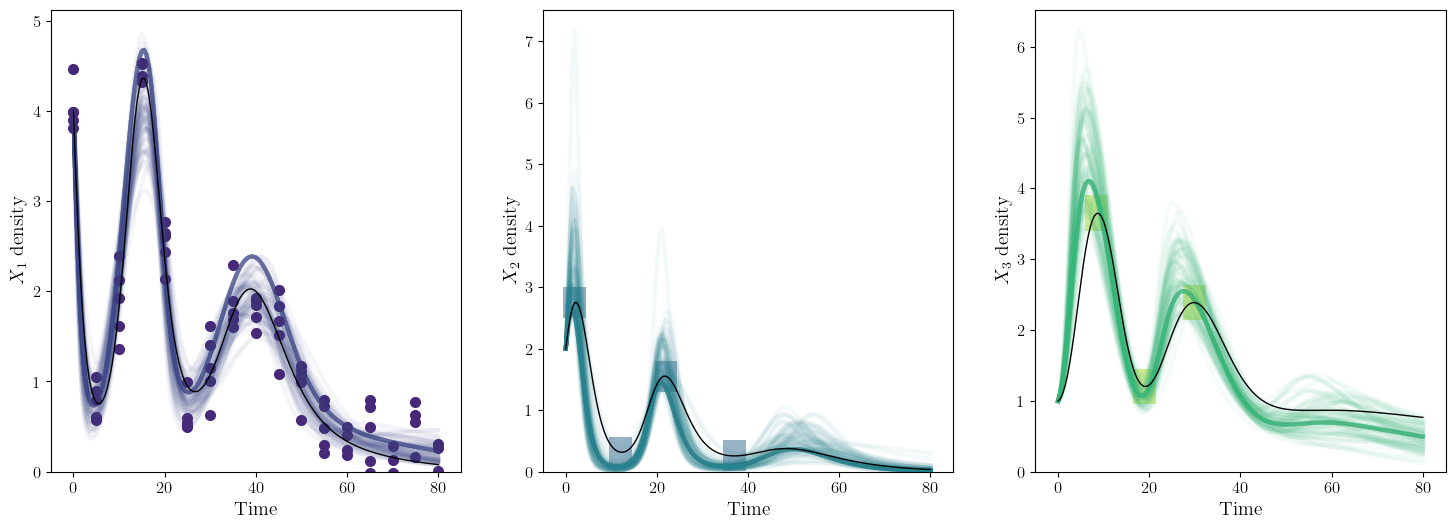

In [124]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5

for i in range(len(dfQual_x2['Time'])):
    rect = plt.Rectangle((dfQual_x2['Time'].values[i]- timeWindow/2, dfQual_x2['X2'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[2], alpha = 0.5)
    axs[1].add_patch(rect)
    
for i in range(len(dfQual_x3['Time'])):
    rect = plt.Rectangle((dfQual_x3['Time'].values[i]- timeWindow/2, dfQual_x3['X3'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), xlabel='Time', ylim=(0))

plt.show()

In [125]:
dfParams_x2x3 = dfParams.drop(columns=['a0', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

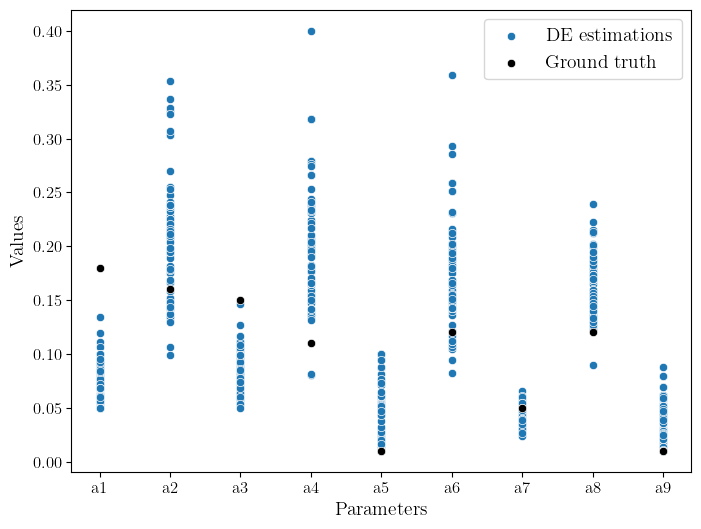

In [126]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

sns.scatterplot(dfParams_x2x3, x='Parameters', y='Values', label='DE estimations')
sns.scatterplot(dfParams_ground, x='Parameters', y='Values', label='Ground truth', color='k')

# Lotka-Volterra equations (Linear model)

\begin{align}
\dot X_1 &= a_0 X_1 - a_2 X_1 X_2 \\
\dot X_2 &= a_4 X_1 X_2 - a_5 X_2 - a_6 X_2 X_3 \\
\dot X_3 &= a_8 X_2 X_3 - a_9 X_3 \\
\end{align}

In [37]:
a0 = 0.14 # Reproduction rate of X1
a1 = 0.0 # Mortality rate of X1
a2 = 0.16 # Rate of predation of X2 on X1
a3 = 0.0 # Reproduction rate of X1 in presence of X3
a4 = 0.15 # Reproduction rate of X2 in presence of X1
a5 = 0.11 # Mortality rate of X2
a6 = 0.05 # Rate of predation of X3 on X2
a7 = 0.0 # Rate of predation of X1 on X3
a8 = 0.06 # Reproduction rate of X3 in presence of X2
a9 = 0.05 # Mortality rate of X3

In [38]:
names=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9']

In [39]:
dfGroundPars = pd.DataFrame([a0, a1, a2, a3, a4, a5, a6, a7, a8, a9]).T
dfGroundPars.columns = names

In [40]:
dfGroundPars

,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9
0,0.14,0.0,0.16,0.0,0.15,0.11,0.05,0.0,0.06,0.05


# Generating data

In [41]:
a0 = dfGroundPars['a0'][0]
a1 = dfGroundPars['a1'][0]
a2 = dfGroundPars['a2'][0]
a3 = dfGroundPars['a3'][0]
a4 = dfGroundPars['a4'][0]
a5 = dfGroundPars['a5'][0]
a6 = dfGroundPars['a6'][0]
a7 = dfGroundPars['a7'][0]
a8 = dfGroundPars['a8'][0]
a9 = dfGroundPars['a9'][0]

In [42]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)
dt = t[1]-t[0]

In [43]:
sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))

In [44]:
X1_g = sol[:,0]
X2_g = sol[:,1]
X3_g = sol[:,2]

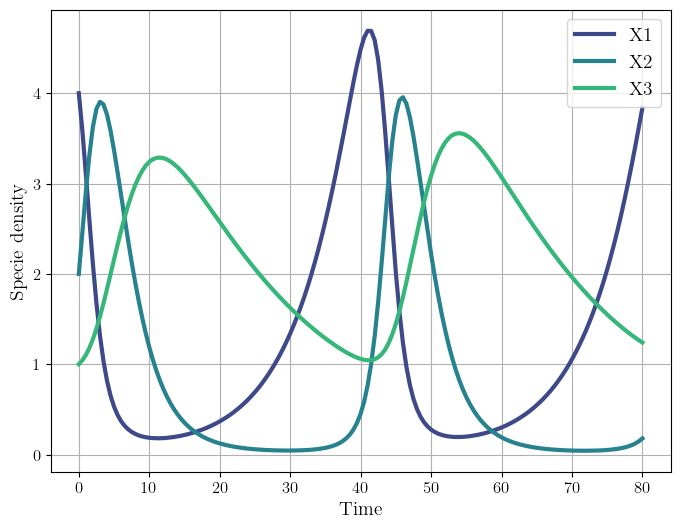

In [45]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

axs.plot(t, X1_g, lw=3, color=palette[1], label='X1')
axs.plot(t, X2_g, lw=3, color=palette[3], label='X2')
axs.plot(t, X3_g, lw=3, color=palette[5], label='X3')
axs.legend(loc='best')
axs.set_xlabel('Time')
axs.set_ylabel('Specie density')
axs.grid()

plt.show()

In [46]:
# dfData_clean = pd.DataFrame(np.transpose([t[0::10],X1_g[0::10],X2_g[0::10],X3_g[0::10]]), columns=['Time','X1','X2','X3'])
dfData_clean = pd.DataFrame(np.transpose([t, X1_g, X2_g, X3_g]), columns=['Time','X1','X2','X3'])

In [47]:
dfData_clean.to_csv('linear/LVdata_clean.data', sep=' ', index=False, float_format='%.2f')
# dfData_noise.to_csv('linear/LVdata_noise.data', sep=' ', index=False, float_format='%.2f')

# Recovering parameters
## Qualitative X3

In [48]:
dfData = pd.read_csv('linear/LVdata_noise.data', sep=' ')
dfQual_x3 = pd.read_csv('linear/LVdata_qual_x3.data', sep=' ')

In [49]:
dfParams = pd.read_csv('linear/bestPars_x3.dat', sep=' ', names=names)

In [50]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

In [51]:
for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

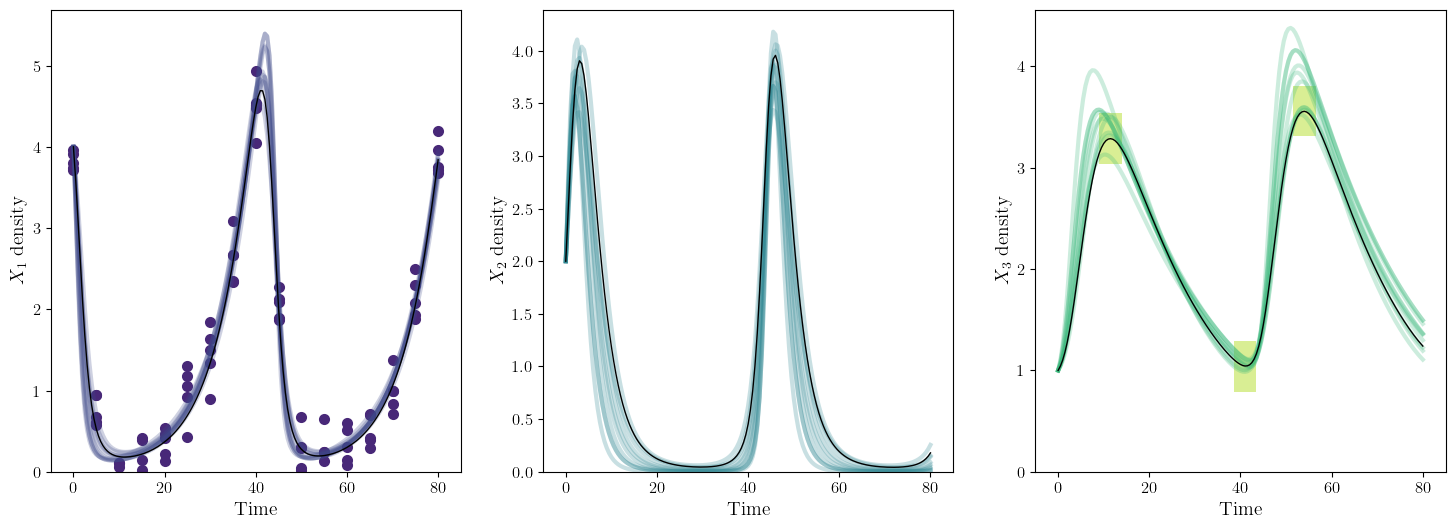

In [52]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.25)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.25)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.25)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5
for i in range(len(dfQual_x3['Time'])):
    rect = plt.Rectangle((dfQual_x3['Time'].values[i]- timeWindow/2, dfQual_x3['X3'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), xlabel='Time', ylim=(0))

plt.show()

In [53]:
df1 = dfParams.melt(var_name='Parameters', value_name='Values')

In [54]:
df2 = dfGroundPars.melt(var_name='Parameters', value_name='Values')

<Axes: xlabel='Parameters', ylabel='Values'>

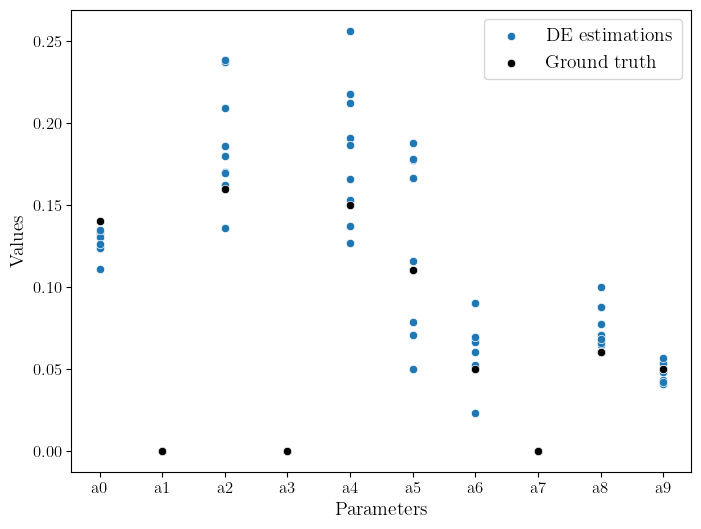

In [55]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

sns.scatterplot(df1, x='Parameters', y='Values', label='DE estimations')
sns.scatterplot(df2, x='Parameters', y='Values', label='Ground truth', color='k')

## Qualitative X2 and X3

In [56]:
dfData = pd.read_csv('linear/LVdata_noise.data', sep=' ')
dfQual_x3 = pd.read_csv('linear/LVdata_qual_x3.data', sep=' ')
dfQual_x2 = pd.read_csv('linear/LVdata_qual_x2.data', sep=' ')

In [57]:
dfParams = pd.read_csv('linear/bestPars_x2x3.dat', sep=' ', names=names)

In [58]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

In [59]:
for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

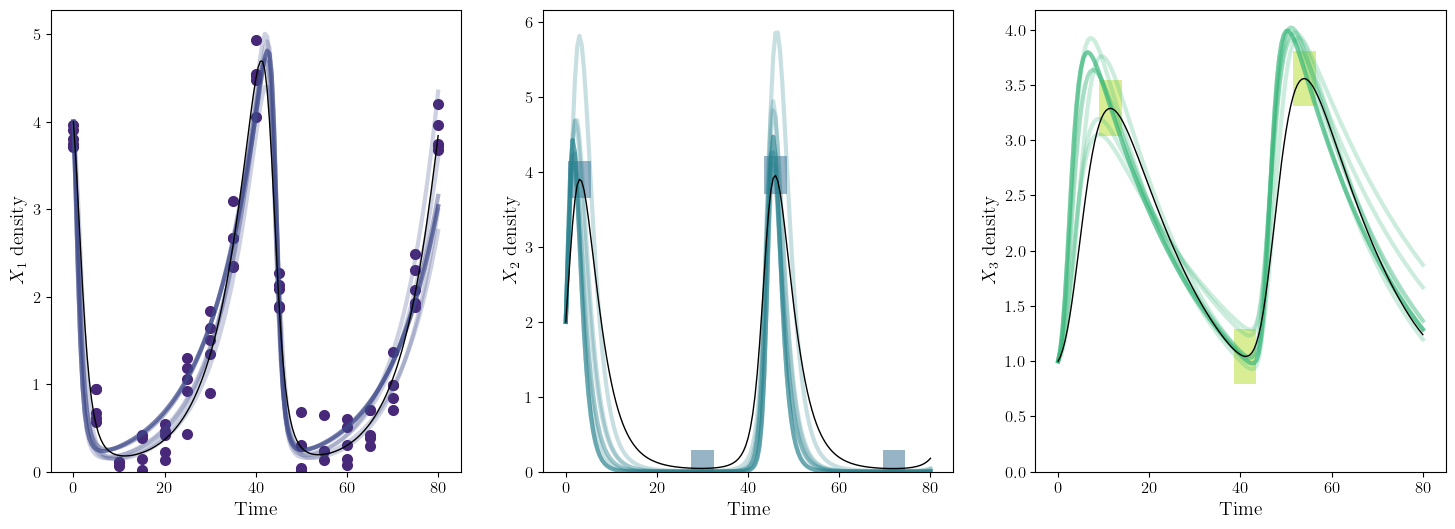

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.25)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.25)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.25)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5

for i in range(len(dfQual_x2['Time'])):
    rect = plt.Rectangle((dfQual_x2['Time'].values[i]- timeWindow/2, dfQual_x2['X2'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[2], alpha = 0.5)
    axs[1].add_patch(rect)
    
for i in range(len(dfQual_x3['Time'])):
    rect = plt.Rectangle((dfQual_x3['Time'].values[i]- timeWindow/2, dfQual_x3['X3'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), xlabel='Time', ylim=(0))

plt.show()

In [61]:
df1 = dfParams.melt(var_name='Parameters', value_name='Values')

In [62]:
df2 = dfGroundPars.melt(var_name='Parameters', value_name='Values')

<Axes: xlabel='Parameters', ylabel='Values'>

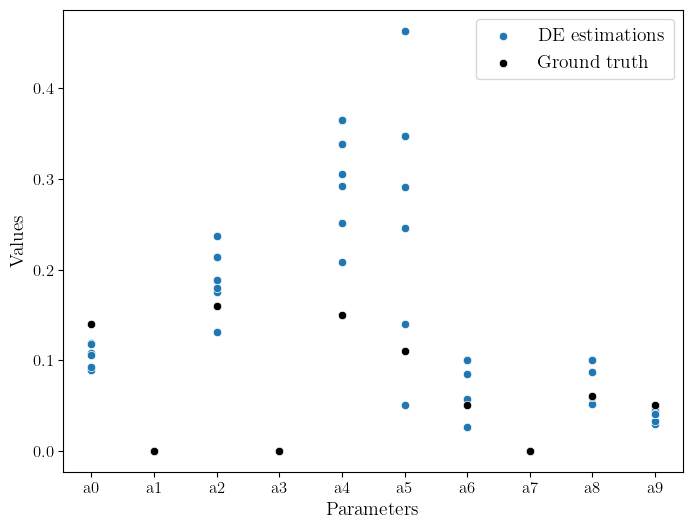

In [63]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

sns.scatterplot(df1, x='Parameters', y='Values', label='DE estimations')
sns.scatterplot(df2, x='Parameters', y='Values', label='Ground truth', color='k')

## Fixing one parameter: Qualitative X2 and X3

In [64]:
dfData = pd.read_csv('linear/LVdata_noise.data', sep=' ')
dfQual_x3 = pd.read_csv('linear/LVdata_qual_x3.data', sep=' ')
dfQual_x2 = pd.read_csv('linear/LVdata_qual_x2.data', sep=' ')

In [65]:
dfParams = pd.read_csv('linear/bestPars_fix.dat', sep=' ', names=names)

In [66]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

In [67]:
for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

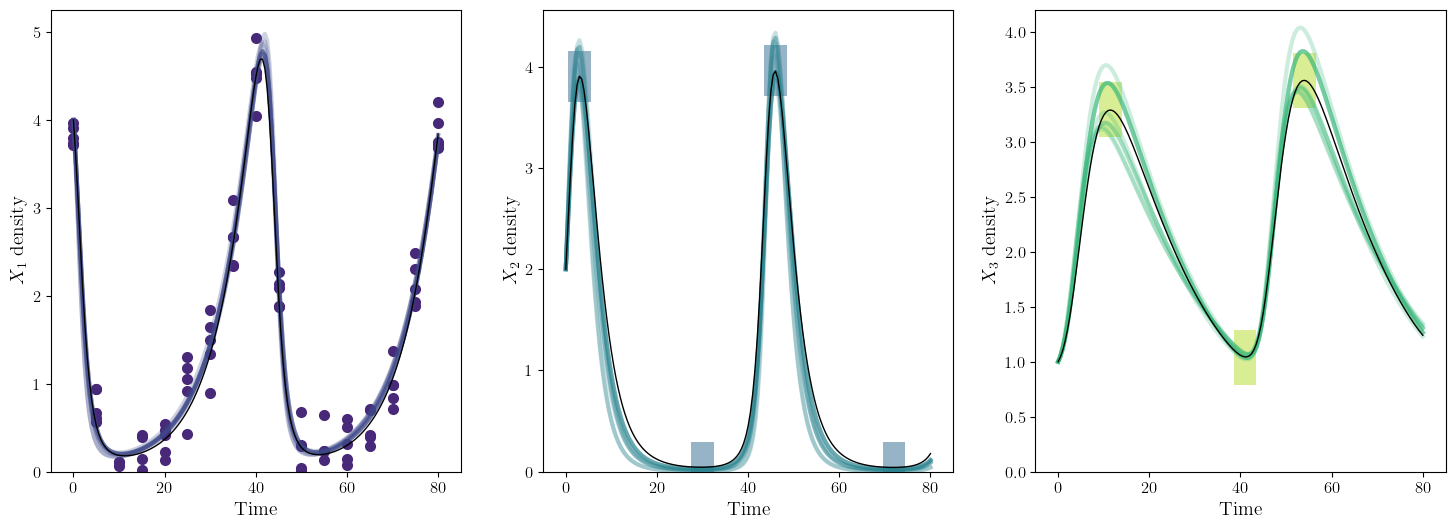

In [68]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.25)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.25)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.25)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5

for i in range(len(dfQual_x2['Time'])):
    rect = plt.Rectangle((dfQual_x2['Time'].values[i]- timeWindow/2, dfQual_x2['X2'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[2], alpha = 0.5)
    axs[1].add_patch(rect)
    
for i in range(len(dfQual_x3['Time'])):
    rect = plt.Rectangle((dfQual_x3['Time'].values[i]- timeWindow/2, dfQual_x3['X3'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), xlabel='Time', ylim=(0))

plt.show()

In [69]:
df1 = dfParams.melt(var_name='Parameters', value_name='Values')

In [70]:
df2 = dfGroundPars.melt(var_name='Parameters', value_name='Values')

<Axes: xlabel='Parameters', ylabel='Values'>

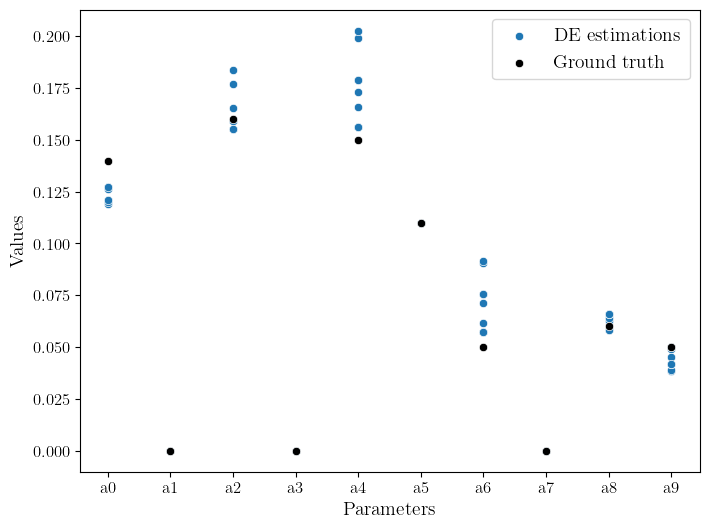

In [71]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

sns.scatterplot(df1, x='Parameters', y='Values', label='DE estimations')
sns.scatterplot(df2, x='Parameters', y='Values', label='Ground truth', color='k')

# Lotka-Volterra equations (2-predators model)

\begin{align}
\dot X_1 &= a_0 X_1 - a_2 X_1 X_2 - a_3 X_1 X_3 \\
\dot X_2 &= a_4 X_1 X_2 - a_5 X_2 \\
\dot X_3 &= a_7 X_1 X_3 - a_9 X_3 \\
\end{align}

In [72]:
a0 = 0.45 # Reproduction rate of X1
a1 = 0.0 # Mortality rate of X1
a2 = 0.16 # Rate of predation of X2 on X1
a3 = -0.15 # Reproduction rate of X1 in presence of X3
a4 = 0.15 # Reproduction rate of X2 in presence of X1
a5 = 0.11 # Mortality rate of X2
a6 = 0.0 # Rate of predation of X3 on X2
a7 = -0.08 # Rate of predation of X1 on X3
a8 = 0.0 # Reproduction rate of X3 in presence of X2
a9 = 0.05 # Mortality rate of X3

In [73]:
names=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9']

In [74]:
dfGroundPars = pd.DataFrame([a0, a1, a2, a3, a4, a5, a6, a7, a8, a9]).T
dfGroundPars.columns = names

In [75]:
dfGroundPars

,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9
0,0.45,0.0,0.16,-0.15,0.15,0.11,0.0,-0.08,0.0,0.05


# Generating data

In [76]:
a0 = dfGroundPars['a0'][0]
a1 = dfGroundPars['a1'][0]
a2 = dfGroundPars['a2'][0]
a3 = dfGroundPars['a3'][0]
a4 = dfGroundPars['a4'][0]
a5 = dfGroundPars['a5'][0]
a6 = dfGroundPars['a6'][0]
a7 = dfGroundPars['a7'][0]
a8 = dfGroundPars['a8'][0]
a9 = dfGroundPars['a9'][0]

In [77]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)
dt = t[1]-t[0]

In [78]:
sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))

In [79]:
X1_g = sol[:,0]
X2_g = sol[:,1]
X3_g = sol[:,2]

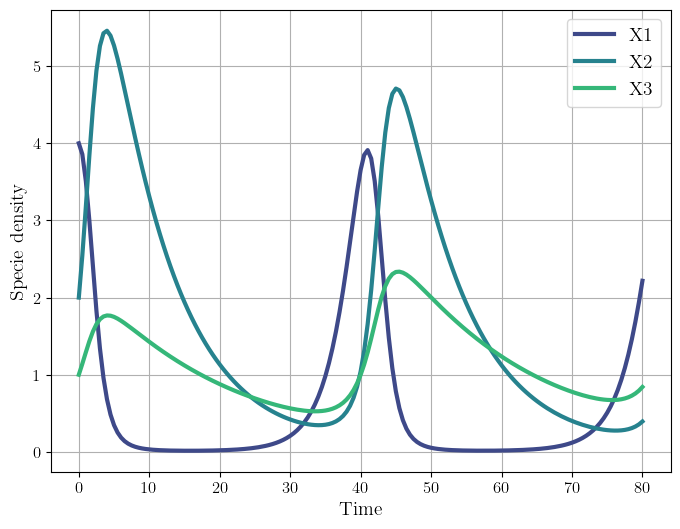

In [80]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

axs.plot(t, X1_g, lw=3, color=palette[1], label='X1')
axs.plot(t, X2_g, lw=3, color=palette[3], label='X2')
axs.plot(t, X3_g, lw=3, color=palette[5], label='X3')
axs.legend(loc='best')
axs.set_xlabel('Time')
axs.set_ylabel('Specie density')
axs.grid()

plt.show()

In [81]:
dfData_clean = pd.DataFrame(np.transpose([t[0::10],X1_g[0::10],X2_g[0::10],X3_g[0::10]]), columns=['Time','X1','X2','X3'])
# dfData_clean = pd.DataFrame(np.transpose([t, X1_g, X2_g, X3_g]), columns=['Time','X1','X2','X3'])

# Recovering parameters
## Qualitative X3

In [82]:
dfData = pd.read_csv('2-predators/LVdata_noise.data', sep=' ')
dfQual_x3 = pd.read_csv('2-predators/LVdata_qual_x3.data', sep=' ')

In [83]:
dfParams = pd.read_csv('2-predators/bestPars_x3.dat', sep=' ', names=names)

In [84]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

In [85]:
for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

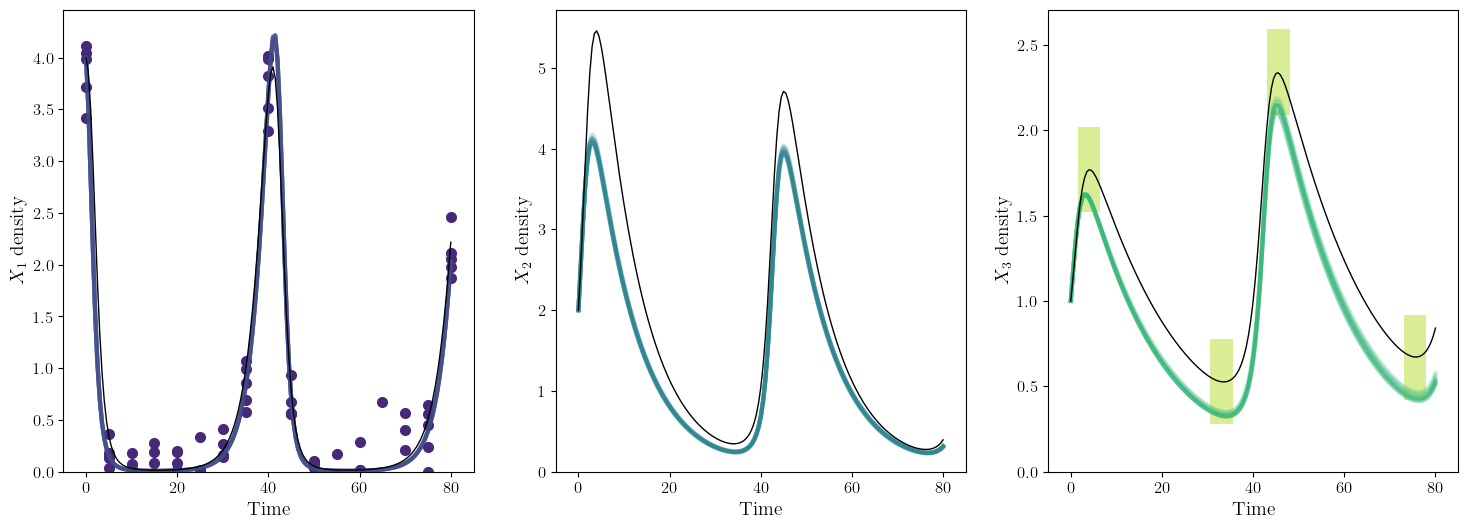

In [86]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.25)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.25)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.25)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5
for i in range(len(dfQual_x3['Time'])):
    rect = plt.Rectangle((dfQual_x3['Time'].values[i]- timeWindow/2, dfQual_x3['X3'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), xlabel='Time', ylim=(0))

plt.show()

In [87]:
df1 = dfParams.melt(var_name='Parameters', value_name='Values')

In [88]:
df2 = dfGroundPars.melt(var_name='Parameters', value_name='Values')

<Axes: xlabel='Parameters', ylabel='Values'>

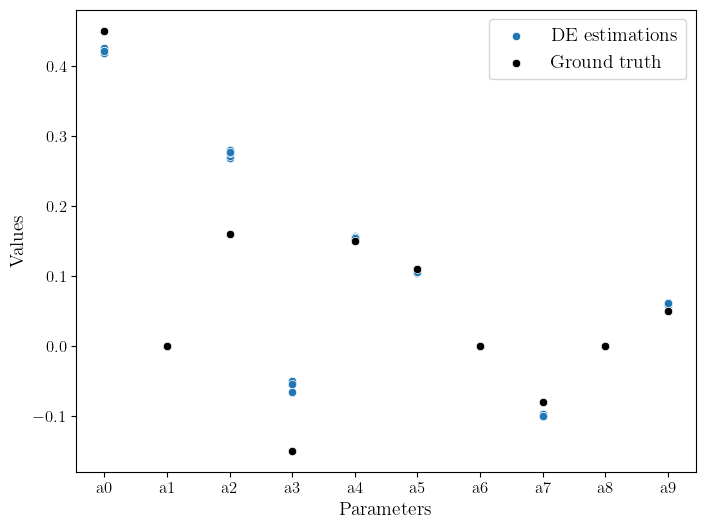

In [89]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

sns.scatterplot(df1, x='Parameters', y='Values', label='DE estimations')
sns.scatterplot(df2, x='Parameters', y='Values', label='Ground truth', color='k')

## Qualitative X2 and X3

In [90]:
dfData = pd.read_csv('2-predators/LVdata_noise.data', sep=' ')
dfQual_x3 = pd.read_csv('2-predators/LVdata_qual_x3.data', sep=' ')
dfQual_x2 = pd.read_csv('2-predators/LVdata_qual_x2.data', sep=' ')

In [91]:
dfParams = pd.read_csv('2-predators/bestPars_x2x3.dat', sep=' ', names=names)

In [92]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

In [93]:
for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

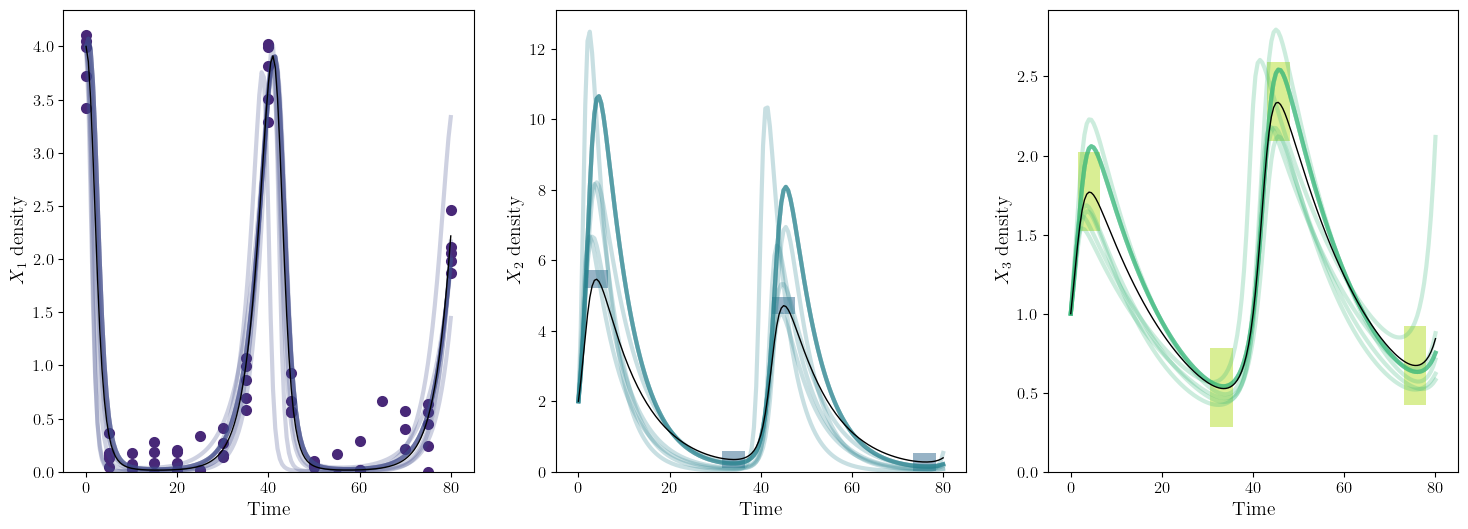

In [94]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.25)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.25)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.25)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5

for i in range(len(dfQual_x2['Time'])):
    rect = plt.Rectangle((dfQual_x2['Time'].values[i]- timeWindow/2, dfQual_x2['X2'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[2], alpha = 0.5)
    axs[1].add_patch(rect)
    
for i in range(len(dfQual_x3['Time'])):
    rect = plt.Rectangle((dfQual_x3['Time'].values[i]- timeWindow/2, dfQual_x3['X3'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), xlabel='Time', ylim=(0))

plt.show()

In [95]:
df1 = dfParams.melt(var_name='Parameters', value_name='Values')

In [96]:
df2 = dfGroundPars.melt(var_name='Parameters', value_name='Values')

<Axes: xlabel='Parameters', ylabel='Values'>

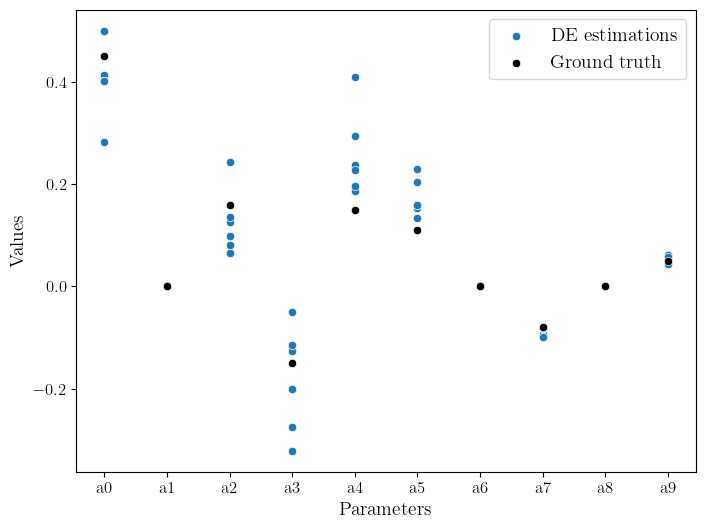

In [97]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

sns.scatterplot(df1, x='Parameters', y='Values', label='DE estimations')
sns.scatterplot(df2, x='Parameters', y='Values', label='Ground truth', color='k')

## Fixing one parameter: Qualitative X2 and X3

In [98]:
dfData = pd.read_csv('2-predators/LVdata_noise.data', sep=' ')
dfQual_x3 = pd.read_csv('2-predators/LVdata_qual_x3.data', sep=' ')
dfQual_x2 = pd.read_csv('2-predators/LVdata_qual_x2.data', sep=' ')

In [99]:
dfParams = pd.read_csv('2-predators/bestPars_fix.dat', sep=' ', names=names)

In [100]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

In [101]:
for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

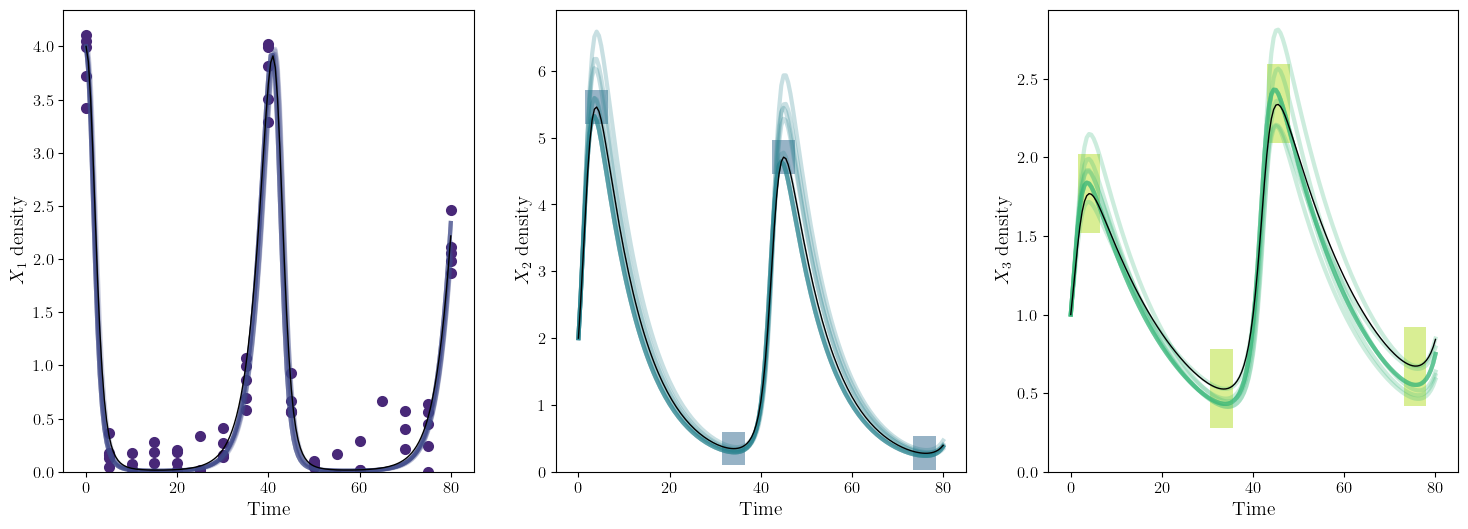

In [102]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.25)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.25)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.25)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5

for i in range(len(dfQual_x2['Time'])):
    rect = plt.Rectangle((dfQual_x2['Time'].values[i]- timeWindow/2, dfQual_x2['X2'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[2], alpha = 0.5)
    axs[1].add_patch(rect)
    
for i in range(len(dfQual_x3['Time'])):
    rect = plt.Rectangle((dfQual_x3['Time'].values[i]- timeWindow/2, dfQual_x3['X3'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), xlabel='Time', ylim=(0))

plt.show()

In [103]:
df1 = dfParams.melt(var_name='Parameters', value_name='Values')

In [104]:
df2 = dfGroundPars.melt(var_name='Parameters', value_name='Values')

<Axes: xlabel='Parameters', ylabel='Values'>

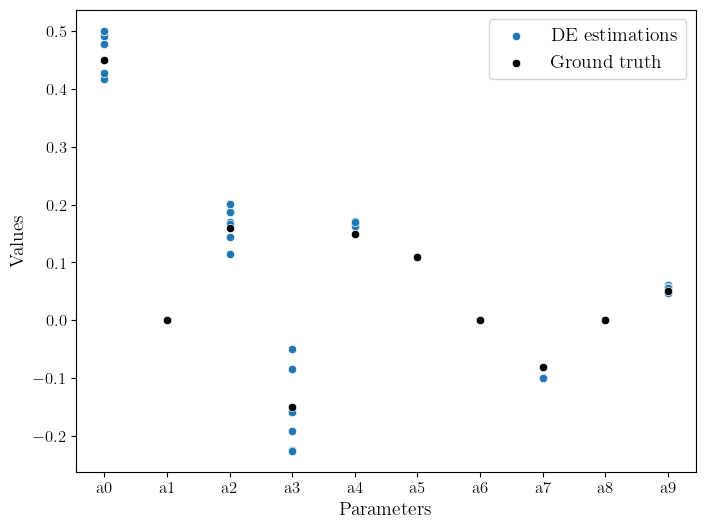

In [105]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

sns.scatterplot(df1, x='Parameters', y='Values', label='DE estimations')
sns.scatterplot(df2, x='Parameters', y='Values', label='Ground truth', color='k')